In [1]:
# Import All Required Libraries
import os
import cv2
import shutil
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from os import makedirs, listdir, path
from random import shuffle, seed, random

from PIL import Image
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

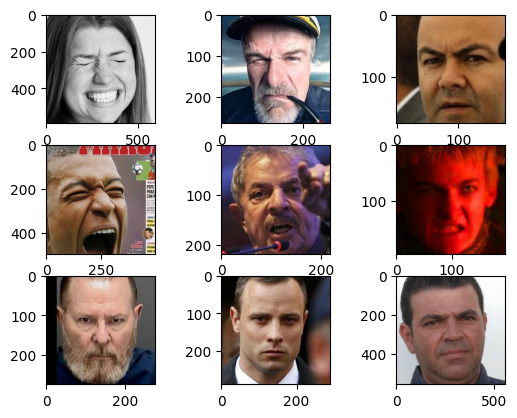

In [5]:
# Define Location Of Dataset And Subfolders
folder = "dataset"
subfolders = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]

# Gather All Image Files
image_files = []

# Choose Emotion To Display
chosen_emotion = "Angry"

# Get All Image Files For Chosen Emotion
for filename in listdir(path.join(folder, f"{chosen_emotion}/")):
  # Get File Name
  name = filename.split("~")[-1]
  # Append Image File
  image_files.append(path.join(folder, chosen_emotion, filename))

# Sort Image Files
image_files = sorted(image_files)

# Display Images
for i in range(9):
  # Create Subplot
  plt.subplot(3, 3, i + 1)
  # Check If Index Is Less Than Length Of Image Files
  if i < len(image_files):
    # Load Image
    image = imread(image_files[i])
    # Display Image
    plt.imshow(image)

# Display Plot
plt.show()

In [87]:
# Define Dataset Folder
dataset_folder = "dataset"

# Initialize Set Of Extensions
extensions = set()

# Loop Through All Files In Dataset Folder
for root, dirs, files in os.walk(dataset_folder):
  # Loop Through All Files
  for file in files:
    # Get Extension
    _, ext = os.path.splitext(file)
    # Add Extension To Set
    extensions.add(ext)

# Display Extensions
print("Extensions:")
for ext in extensions:
  print(ext)

NameError: name 'os' is not defined

In [13]:
# Define Dataset Folder
dataset_folder = "dataset"

# Define Finalized Dataset Folder, Subdirectories, And Extensions
finalized_dataset = "finalized_dataset"
subdirs = ["Angry", "Happy", "Neutral", "Sad", "Surprise"]
extensions = [".jpeg", ".JPEG", ".JPG", ".png", ".bmp", ".PNG", ".jpg"]

# Create Finalized Dataset Folder
for subdir in subdirs:
    # Create Subdirectory
    subdir_path = os.path.join(dataset_folder, subdir)
    # Define Subdirectory Path
    finalized_subdir_path = os.path.join(finalized_dataset, subdir)
    # Create Subdirectory Path
    os.makedirs(finalized_subdir_path, exist_ok=True)
    # Initialize Count
    count = 1
    # Iterate Over Files In Subdirectory
    for filename in os.listdir(subdir_path):
        # Define File Path
        file_path = os.path.join(subdir_path, filename)
        # Iterate Over Extensions
        for extension in extensions:
            # Check If Filename Ends With Extension
            if filename.endswith(extension):
                new_filename = f"{subdir.lower()}.{count}{extension}"
                new_file_path = os.path.join(finalized_subdir_path, new_filename)
                copyfile(file_path, new_file_path)
                count += 1
                break

In [14]:
# Define Dataset Folder Subdirectories And Labels
dataset_home = "dataset_emotions"
subdirs = ["train/", "test/"]
labeldirs = ["Angry/", "Happy/", "Neutral/", "Sad/", "Surprise/"]

# Create Directories
for subdir in subdirs:
  # Create Subdirectory
  for labeldir in labeldirs:
    # Create Label Directory
    newdir = path.join(dataset_home, subdir, labeldir)
    # Make Directory
    makedirs(newdir, exist_ok=True)

# Seed Random Number Generator
seed(1)

# Define Validation Ratio
val_ratio = 0.25

# Define Source Directory
src_directory = "finalized_dataset/"

# Copy Files To Train And Test Directories
for labeldir in labeldirs:
    label = labeldir.strip('/')
    label_src_directory = path.join(src_directory, labeldir)
    # Define Destination Directory
    for file in listdir(label_src_directory):
        src = path.join(label_src_directory, file)
        # Copy To Train Or Test Directory
        dst_dir = "train/" if random() >= val_ratio else "test/"
        dst = path.join(dataset_home, dst_dir, labeldir, file)
        copyfile(src, dst)


In [17]:
# Define Model
def define_model():
  # Load VGG16 Model
  model = VGG16(include_top=False, input_shape=(224, 224, 3))

  # Mark Loaded Layers As Not Trainable
  for layer in model.layers:
    layer.trainable = False

  # Add New Classifier Layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(5, activation='softmax')(class1)

  # Define New Model
  model = Model(inputs=model.inputs, outputs=output)

  # Compile Model
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# Define Test Harness
def run_test_harness():
  # Define Model
  model = define_model()

  # Create Data Generator
  datagen = ImageDataGenerator(featurewise_center=True)

  # Specify Mean Values For Centering
  datagen.mean = [123.68, 116.779, 103.939]

  # Prepare Train Data Generators
  train_it = datagen.flow_from_directory(
    'dataset_emotions/train/', 
    class_mode='categorical', 
    batch_size=128, 
    target_size=(224, 224)
  )

  # Prepare Test Data Generator
  test_it = datagen.flow_from_directory(
    'dataset_emotions/test/', 
    class_mode='categorical', 
    batch_size=128, 
    target_size=(224, 224)
  )
  
  # Define Early Stopping Callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  # Fit Model With 50 Epochs
  model.fit(
    train_it, 
    validation_data=test_it, 
    steps_per_epoch=len(train_it), 
    validation_steps=len(test_it), 
    epochs=50, 
    verbose=1,
    callbacks=[early_stopping]
  )

  # Save Model
  model.save('final_model_emotions.keras')

# Run Test Harness
run_test_harness()

Found 10632 images belonging to 5 classes.
Found 3616 images belonging to 5 classes.


c:\Users\Adrian Danao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Adrian Danao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_22']. Received: the structure of inputs=*
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.2920 - loss: 8.6816 - val_accuracy: 0.3526 - val_loss: 1.3290
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50


c:\Users\Adrian Danao\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
c:\Users\Adrian Danao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.4101 - loss: 1.2549 - val_accuracy: 0.5083 - val_loss: 1.1523
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 96us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.4799 - loss: 1.2067 - val_accuracy: 0.5155 - val_loss: 1.0969
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.5393 - loss: 0.9658 - val_accuracy: 0.5119 - val_loss: 1.0931
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 80us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.5525 - loss: 0.8922 - val_accuracy: 0.5393 - val_loss: 1.1035
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.5939 - loss: 0.8100 - val_accuracy: 0.5221 - val_loss: 1.1463


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted category: Sad (23.02%)
Angry: 20.91%
Happy: 16.54%
Neutral: 19.63%
Sad: 23.02%
Surprised: 19.90%


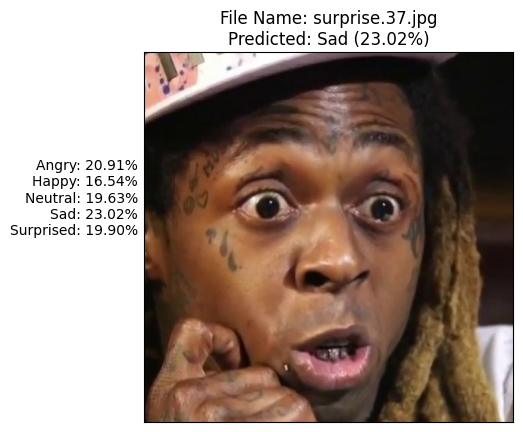

In [86]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Define Function To Load And Preprocess Image
def load_image(filename):
    # Load the image and resize it to the required input size for the model
    img = load_img(filename, target_size=(224, 224))
    # Convert the image to a NumPy array
    img = img_to_array(img)
    # Reshape the image to add a batch dimension (1, 224, 224, 3)
    img = img.reshape(1, 224, 224, 3)
    # Convert pixel values to float32 for consistency in processing
    img = img.astype('float32')
    # Subtract the mean RGB values to normalize the image (preprocessing for VGG16)
    img = img - [123.68, 116.779, 103.939]
    return img

def run_example(filename):
    # Preprocess the input image
    img = load_image(filename)
    # Load the pre-trained model for emotion classification
    model = load_model('final_model_emotions.keras')
    # Make predictions on the input image
    result = model.predict(img)

    # Define the categories corresponding to the output classes
    categories = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]
    # Get the index of the highest probability (predicted class)
    predicted_class = np.argmax(result[0])
    # Map the predicted class index to its label
    predicted_label = categories[predicted_class]
    # Get the confidence percentage for the predicted class
    predicted_percentage = result[0][predicted_class] * 100

    # Print the predicted category and its confidence percentage
    print(f"Predicted category: {predicted_label} ({predicted_percentage:.2f}%)")

    # Print the confidence percentages for all categories
    for i, category in enumerate(categories):
        print(f"{category}: {result[0][i] * 100:.2f}%")

    # Prepare a text string showing all categories and their confidence percentages
    percentages_text = "\n".join([f"{category}: {result[0][i] * 100:.2f}%" for i, category in enumerate(categories)])

    # Load the original image for visualization
    original_img = load_img(filename)
    # Display the image with prediction results
    plt.imshow(original_img)
    plt.title(f"File Name: {filename.split('/')[-1]}\nPredicted: {predicted_label} ({predicted_percentage:.2f}%)")
    # Add a label below the image with all category percentages
    plt.ylabel(percentages_text, rotation="horizontal", ha="right")
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.show()

emotion = input("Enter category (Must Be in Title Case): ")
number = int(input("Enter which image number you want to predict: "))
extension = input("Enter extension: ")

# Run the example with a test image
run_example(f'dataset_emotions/test/{emotion}/{emotion.lower()}.{number}.{extension}')